# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/)
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data its received is real or fake.

>* The generator is trained to fool the discriminator, it wants to output data that looks as *close as possible* to the real, training data. 
>* The discriminator is a classifier that is trained to figure out which data is real and which is fake.

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/raw/3a95d118f9df5a86826e1791c5c100817f0fd924/gan-mnist/assets/gan_pipeline.png" width=500>

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called a **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, we will define and train these adversarial networks in PyTorch and generate new images!

In [2]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, 
                            transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


### Visualize the data

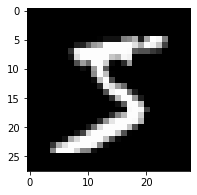

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:

> All hidden layers will have a [Leaky ReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/raw/3a95d118f9df5a86826e1791c5c100817f0fd924/gan-mnist/assets/gan_network.png" width=300>

#### Leaky ReLU

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/raw/3a95d118f9df5a86826e1791c5c100817f0fd924/gan-mnist/assets/leaky_relu.png" width=300>

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is *real* or *fake*.

> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function.

So, our final output layer should not have any activation function applied to it.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        # define hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

        # final, fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)

        # pass x through all layers
        # apply leaky ReLU ativation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.fc4(x)
        return x

In [22]:
disc = Discriminator(784, 200, 10)

In [23]:
disc.forward(torch.tensor(images[0]))

tensor([[ 0.0284, -0.1187, -0.1618, -0.1345,  0.0494,  0.0249,  0.0012, -0.2166,
         -0.0287, -0.0841]], grad_fn=<AddmmBackward>)

In [31]:
torch.tensor(images[0]).view(1, -1).shape

torch.Size([1, 784])